## Anomaly Detection Model - FIRST

### Modellbeschreibung:

- Training auf den Jahren 2020 und 2021
- Adam als Opzimizer
- Komplexerer AE
- Mehr als 6 Epochen
- Normalisierung der Daten
- Modell wie aus der Vorstudie

### Imports

In [1]:
%run -i ./scripts/PythonImports.py

### Set Configs and load data

In [2]:
%run -i ./scripts/TrainPreperations.py

Shape of normal data: (105216, 17)
Shape of anormal data: (35040, 18)


### Skalieren der Daten & "Column name zu Zahl"-Mapping speichern & Daten für PyTorch vorbereiten

In [3]:
%run -i ./scripts/ScaleAndPrepare.py

##  Training

In [4]:
from models.SimpleAutoEncoder import SimpleAutoEncoder
torch.manual_seed(42)

In [5]:
num_inputs = len(df_data.columns)
print('Num Inputs: {}'.format(num_inputs))

val_lambda = 0.5
model = SimpleAutoEncoder(num_inputs=num_inputs, val_lambda=val_lambda)
critereon = mse_loss
optimizer = Adam(model.parameters())

print(model)

Num Inputs: 17
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


In [6]:
losses = []
EPOCHS = 32
for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data,target) in enumerate(trn_dataloader):
        data = torch.autograd.Variable(data)
        optimizer.zero_grad()
        pred = model(data)
        loss = critereon(pred, data)
        losses.append(loss.cpu().data.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Display
        if batch_idx % 50 == 1:
            print('\n Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(trn_dataloader.dataset),
                100. * batch_idx / len(trn_dataloader), 
                loss.cpu().data.item()), 
                end='')


 Train Epoch: 1/32 [128/105216 (0%)]	Loss: 0.318232
 Train Epoch: 1/32 [6528/105216 (6%)]	Loss: 0.302905
 Train Epoch: 1/32 [12928/105216 (12%)]	Loss: 0.162769
 Train Epoch: 1/32 [19328/105216 (18%)]	Loss: 0.090886
 Train Epoch: 1/32 [25728/105216 (24%)]	Loss: 0.052184
 Train Epoch: 1/32 [32128/105216 (31%)]	Loss: 0.052721
 Train Epoch: 1/32 [38528/105216 (37%)]	Loss: 0.049132
 Train Epoch: 1/32 [44928/105216 (43%)]	Loss: 0.046855
 Train Epoch: 1/32 [51328/105216 (49%)]	Loss: 0.045942
 Train Epoch: 1/32 [57728/105216 (55%)]	Loss: 0.029837
 Train Epoch: 1/32 [64128/105216 (61%)]	Loss: 0.024614
 Train Epoch: 1/32 [70528/105216 (67%)]	Loss: 0.030230
 Train Epoch: 1/32 [76928/105216 (73%)]	Loss: 0.048548
 Train Epoch: 1/32 [83328/105216 (79%)]	Loss: 0.011161
 Train Epoch: 1/32 [89728/105216 (85%)]	Loss: 0.034344
 Train Epoch: 1/32 [96128/105216 (91%)]	Loss: 0.012327
 Train Epoch: 1/32 [102528/105216 (97%)]	Loss: 0.019800
 Train Epoch: 2/32 [128/105216 (0%)]	Loss: 0.018064
 Train Epoch: 2/

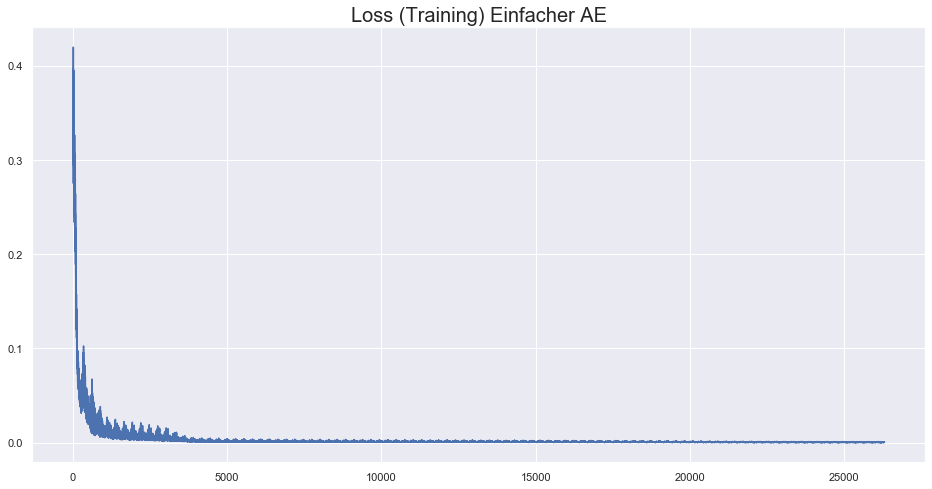

In [8]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.arange(len(losses)),losses)
plt.title('Loss (Training) Einfacher AE',fontsize=20)
loss_fn = '{}_AE_model_loss.pdf'.format(arrow.now().format('YYYYMMDD'))
fn = os.path.join(fig_path, loss_fn)
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0)

### Save Modell

In [9]:
model_fn = '{}_firstAE_model.pt'.format(arrow.now().format('YYYYMMDD'))
print('Model Name: {}'.format(model_fn))
torch.save(model.state_dict(), os.path.join(model_bib_path, model_fn))

Model Name: 20200303_firstAE_model.pt


# Logistic Regression zum Lernen des Thresholds

In [10]:
from sklearn.linear_model import LogisticRegression
from utils.evalUtils import calc_cm_metrics

from models.SimpleAutoEncoder import SimpleAutoEncoder
torch.manual_seed(42)

In [24]:
s_labels = df_data_anormal['label']
df_data_anormal.drop('label', axis=1, inplace=True)

In [16]:
num_inpus = len(df_data_anormal.columns)
val_lambda = 42 * 0.01
fn_now = os.path.join(model_path, 'model_bib' ,'20200303_firstAE_model.pt')
model = SimpleAutoEncoder(num_inputs=num_inpus, val_lambda=val_lambda)
model.load_state_dict(torch.load(fn_now))
model.eval()

SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)

In [17]:
data_fn_anormal = os.path.join(data_path, 'anomalous_data_y_2022_reduced.h5')
df_data_anormal = pd.read_hdf(data_fn_anormal, key='df')
print('Shape of anormal data: {}'.format(df_data_anormal.shape))

Shape of anormal data: (35040, 18)


In [18]:
scaler_train = MinMaxScaler((-1,1))

In [19]:
scaler_train = scaler_train.fit(df_data)

In [25]:
df_data_anormal.shape

(35040, 17)

In [26]:
scaled_anormal = scaler_train.transform(df_data_anormal.to_numpy())

In [27]:
# build tensor from numpy
anormal_torch_tensor = torch.from_numpy(scaled_anormal).type(torch.FloatTensor)

In [28]:
# build TensorDataset from Tensor
anormal_dataset = TensorDataset(anormal_torch_tensor, anormal_torch_tensor)

In [29]:
# build DataLoader from TensorDataset
anormal_dataloader = torch.utils.data.DataLoader(anormal_dataset,batch_size=128,shuffle=False, num_workers=0)

In [30]:
losses_anormal = []
for val in anormal_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_anormal.append(loss.item())
    
s_losses_anormal = pd.Series(losses_anormal)

In [31]:
X = s_losses_anormal.to_numpy()
X = X.reshape(-1, 1)
y = [1 if x > 0 else 0 for x in s_labels]

In [32]:
clf = LogisticRegression(random_state=42, fit_intercept=True, solver='liblinear', class_weight={1:2.0})
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
predictions = []
for val in X:
    val = val.reshape(1,-1)
    pred = clf.predict(val)
    predictions.append(pred[0])

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
import joblib

In [35]:
cm = confusion_matrix(y, predictions)
tn, fp, fn, tp  = confusion_matrix(y, predictions).ravel()

In [36]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 99.70034246572497
Precision: 99.99999999958195
Specifity: 93.15299842562096
Sensitivity: 95.79495394435004
F1-Score: 97.85232153794672


### Save Model

In [38]:
model_fn = '{}_LogRegModell.save'.format(arrow.now().format('YYYYMMDD'))
filename = os.path.join(model_bib_path, model_fn)
joblib.dump(clf, filename)

['/Users/torge/Development/master/masterthesis_code/02_Experimente/AnomalyDetection/models/model_bib/20200303_LogRegModell.save']